# Чем лучше бустить? Тестируем алгоритмы бустинга в бою.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

Часть 1. EDA, Часть 2. Preprocessing & Feature Engineering

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,classification_report, precision_score, recall_score, f1_score
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)

In [4]:
data = pd.read_csv('/content/drive/MyDrive/STUDY/otus/HW/3/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


проверка на дубликаты

In [6]:
data[data.duplicated(['customerID'], keep=False)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [7]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
data.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


проверим на пропуски

In [11]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

удалим лишнюю колонку

In [12]:
data.drop(columns=['customerID'], inplace = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a20ff90d0>,
      dtype=object)

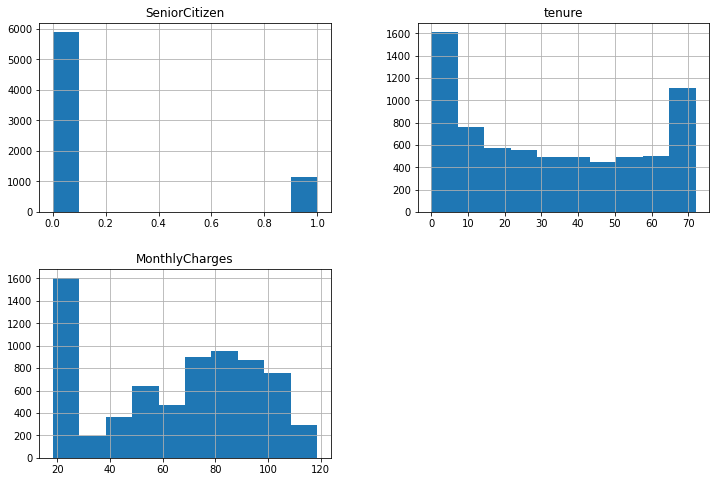

In [13]:
data.hist()

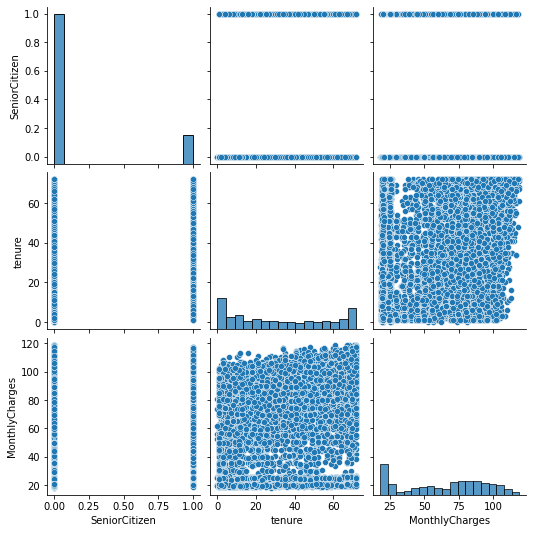

In [14]:
sns.pairplot(data)

### Target: Churn

Text(0.5, 1.0, 'Распределение оттока клиентов')

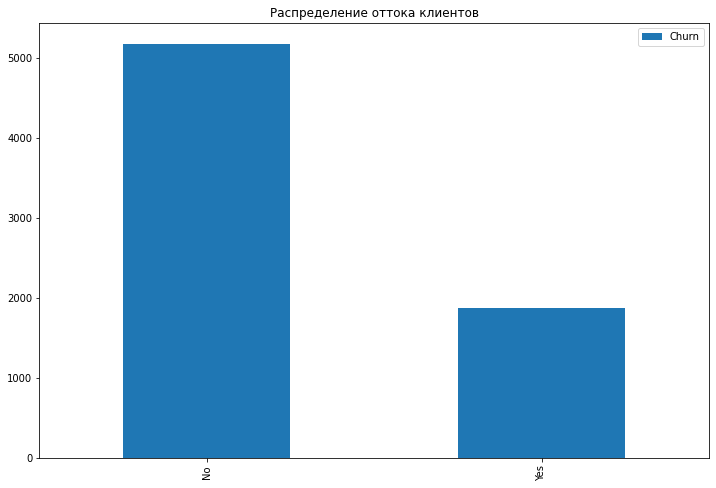

In [15]:
data['Churn'].value_counts().plot(kind='bar', label='Churn').legend()
plt.title('Распределение оттока клиентов')

оцифруем целевую переменную

In [16]:
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

### gender 

In [17]:
data.gender.value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

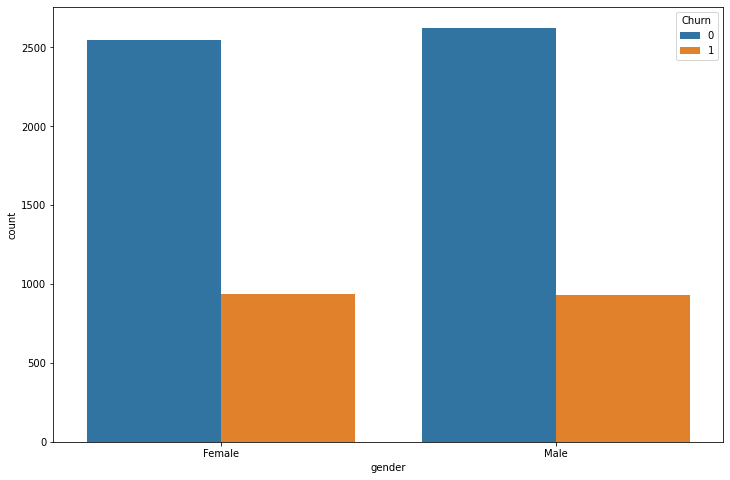

In [18]:
sns.countplot(x='gender', hue='Churn', data=data);

закодируем, используя label encoder. Его т.к. будем работать с "деревянными" моделями

In [19]:
le = LabelEncoder()

In [20]:
data.gender = le.fit_transform(data.gender)

### SeniorCitizen

In [21]:
data.SeniorCitizen.value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

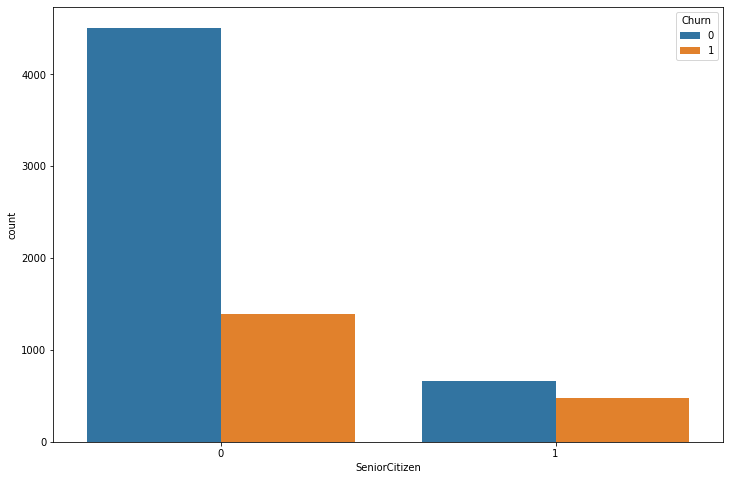

In [22]:
sns.countplot(x='SeniorCitizen', hue='Churn', data=data);

In [23]:
data.SeniorCitizen = le.fit_transform(data.SeniorCitizen)

### Partneer

In [24]:
data.Partner.value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

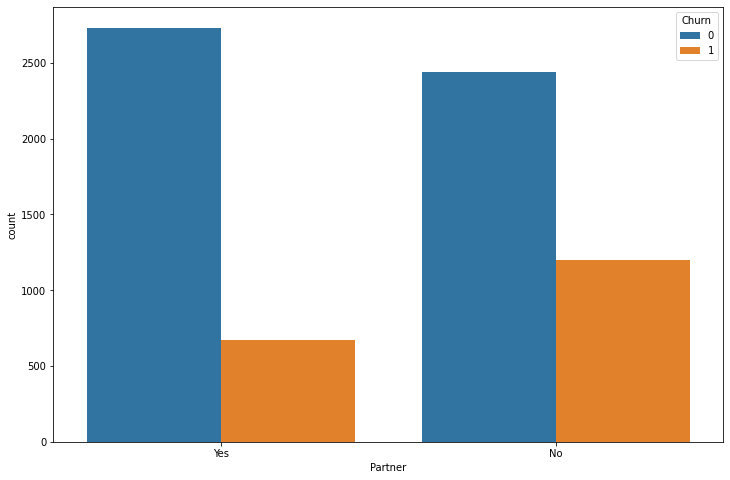

In [25]:
sns.countplot(x='Partner', hue='Churn', data=data);

интересный признак, люди без партнера чаще уходят от оператора, возможно это связано с тем, что одному проще сменить оператора. В паре нужно менять всем,т.к. звонки между одним и тем же оператором - дешевле

In [26]:
data.Partner = le.fit_transform(data.Partner)

### Dependents

In [27]:
data.Dependents.value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

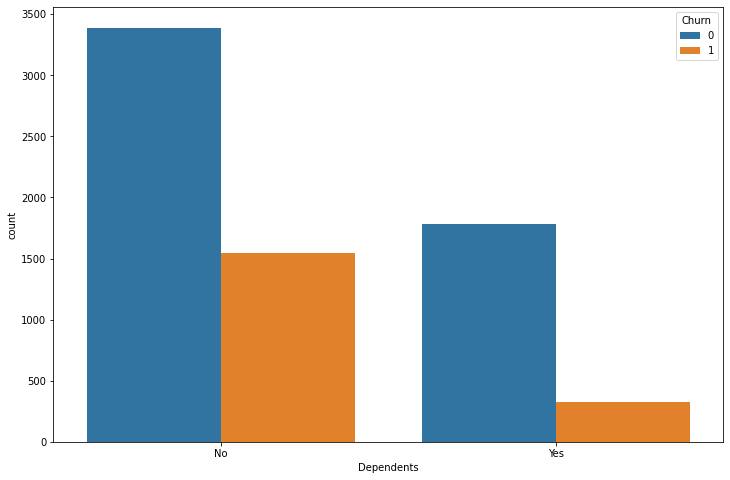

In [28]:
sns.countplot(x='Dependents', hue='Churn', data=data);

клиенты без иждивенцев чаще уходят

In [29]:
data.Dependents = le.fit_transform(data.Dependents)

### tenure

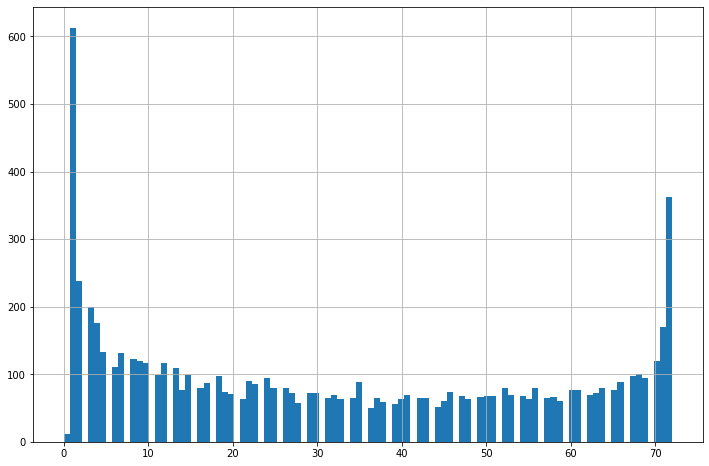

In [30]:
data.tenure.hist(bins = 100)

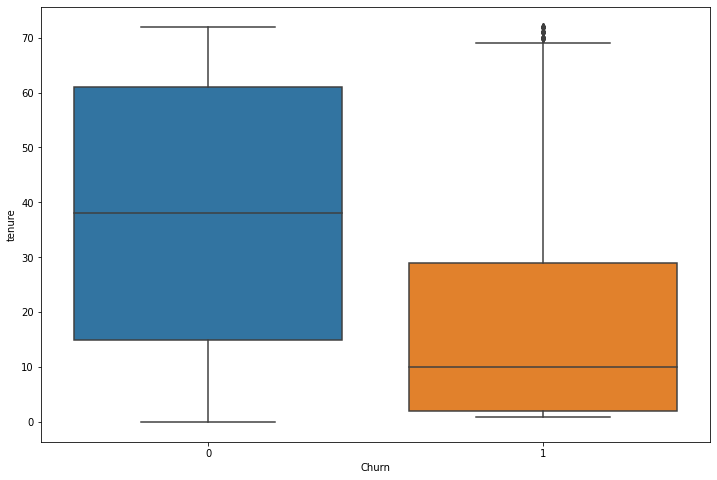

In [31]:
sns.boxplot(x='Churn', y='tenure', data=data)

видим, что иим что уходящие пользуются связью не так долго как постоянные клиенты

### PhoneService

In [32]:
data.PhoneService.value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

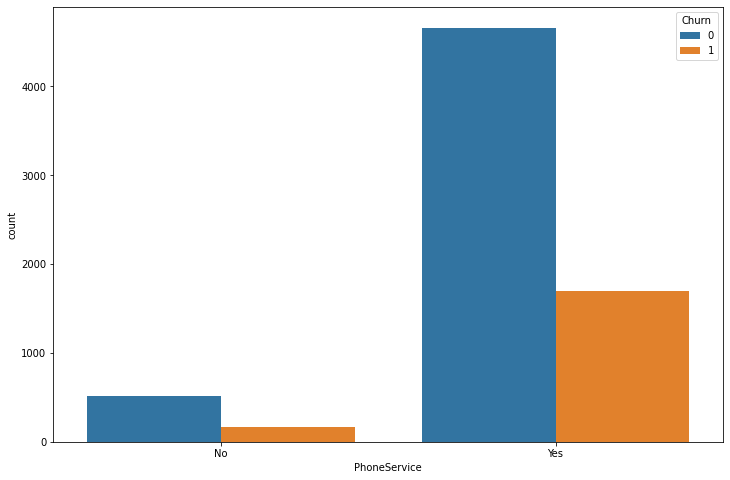

In [33]:
sns.countplot(x='PhoneService', hue='Churn', data=data);

In [34]:
data.PhoneService = le.fit_transform(data.PhoneService)

### MultipleLines

In [35]:
data.MultipleLines.value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

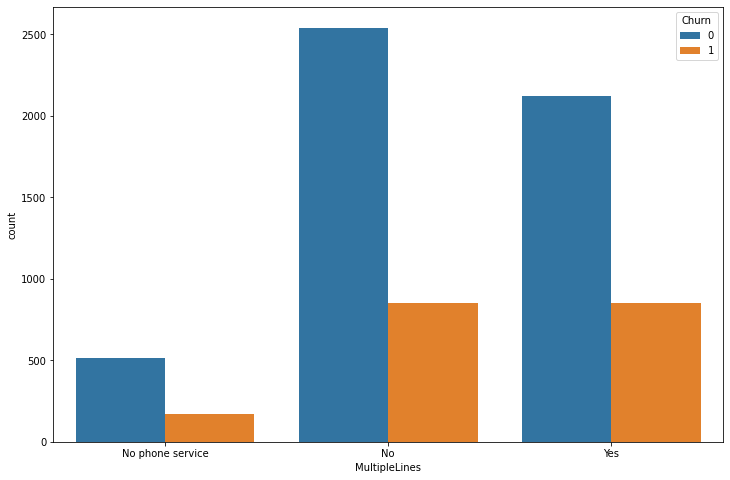

In [36]:
sns.countplot(x='MultipleLines', hue='Churn', data=data);

In [37]:
data.MultipleLines = le.fit_transform(data.MultipleLines)

### InternetService

In [38]:
data.InternetService.value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

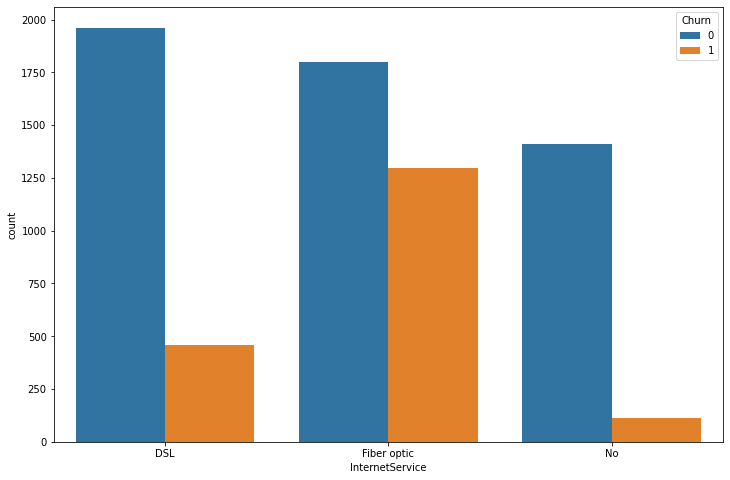

In [39]:
sns.countplot(x='InternetService', hue='Churn', data=data);

интересное замечание, клиенты с оптоволокном лидируют по оттоку..

In [40]:
data.InternetService = le.fit_transform(data.InternetService)

### OnlineSecurity

In [41]:
data.OnlineSecurity.value_counts()

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

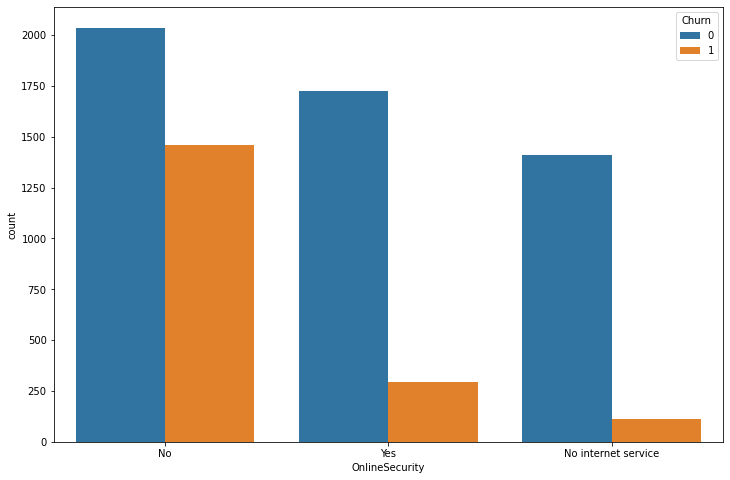

In [42]:
sns.countplot(x='OnlineSecurity', hue='Churn', data=data);

In [43]:
data.OnlineSecurity = le.fit_transform(data.OnlineSecurity)

### OnlineBackup

In [44]:
data.OnlineBackup.value_counts()

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

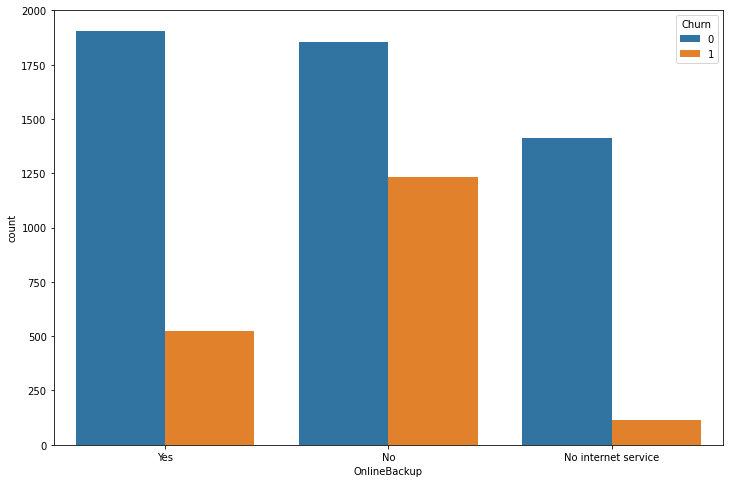

In [45]:
sns.countplot(x='OnlineBackup', hue='Churn', data=data);

In [46]:
data.OnlineBackup = le.fit_transform(data.OnlineBackup)

### DeviceProtection

In [47]:
data.DeviceProtection.value_counts()

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

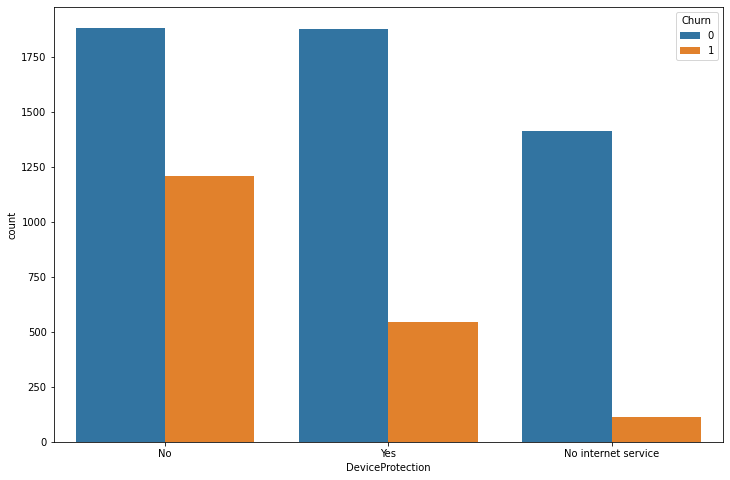

In [48]:
sns.countplot(x='DeviceProtection', hue='Churn', data=data);

In [49]:
data.DeviceProtection = le.fit_transform(data.DeviceProtection)

### TechSupport

In [50]:
data.TechSupport.value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

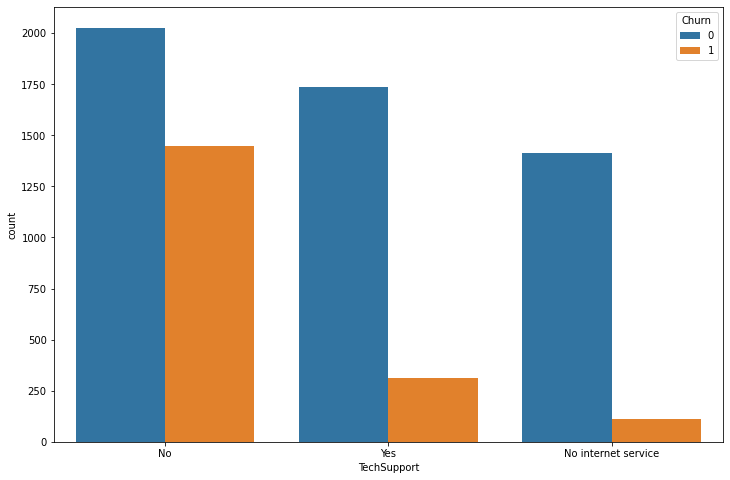

In [51]:
sns.countplot(x='TechSupport', hue='Churn', data=data);

In [52]:
data.TechSupport = le.fit_transform(data.TechSupport)

### StreamingTV

In [53]:
data.StreamingTV.value_counts()

No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64

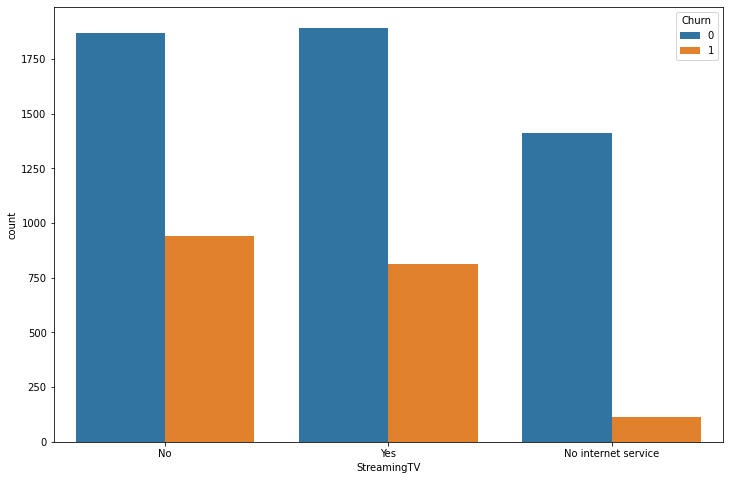

In [54]:
sns.countplot(x='StreamingTV', hue='Churn', data=data);

In [55]:
data.StreamingTV = le.fit_transform(data.StreamingTV)

### StreamingMovies

In [56]:
data.StreamingMovies.value_counts()

No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64

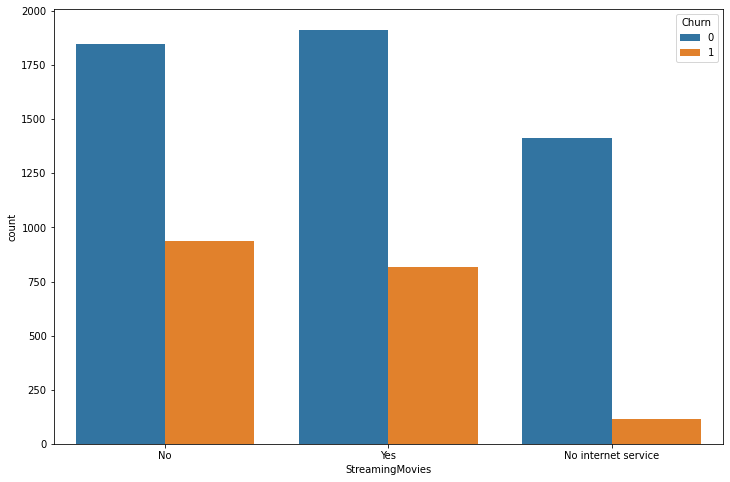

In [57]:
sns.countplot(x='StreamingMovies', hue='Churn', data=data);

In [58]:
data.StreamingMovies = le.fit_transform(data.StreamingMovies)

In [59]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,One year,No,Mailed check,56.95,1889.5,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,Month-to-month,Yes,Electronic check,70.70,151.65,1


### Contract

In [60]:
data.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

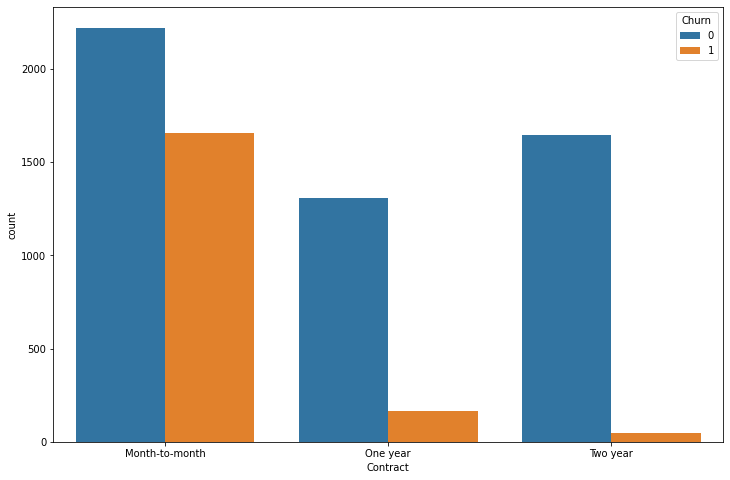

In [61]:
sns.countplot(x='Contract', hue='Churn', data=data);

крутой признак, месячники уходят чаще

In [62]:
data.Contract = le.fit_transform(data.Contract)

### PaperlessBilling

In [63]:
data.PaperlessBilling.value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

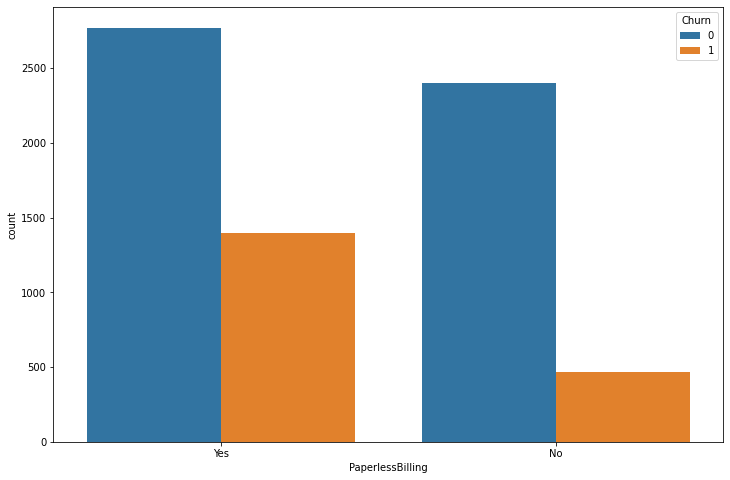

In [64]:
sns.countplot(x='PaperlessBilling', hue='Churn', data=data);

In [65]:
data.PaperlessBilling = le.fit_transform(data.PaperlessBilling)

### PaymentMethod

In [66]:
data.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

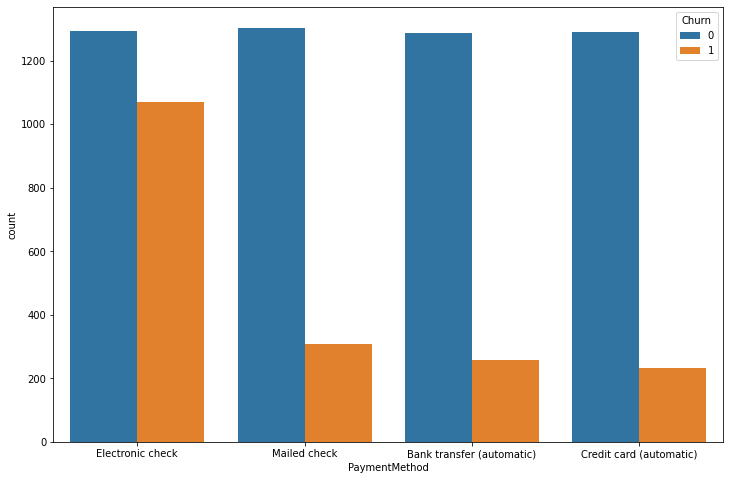

In [67]:
sns.countplot(x='PaymentMethod', hue='Churn', data=data);

электронные чеки это плохо...

In [68]:
data.PaymentMethod = le.fit_transform(data.PaymentMethod)

In [69]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.5,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


### MonthlyCharges	TotalCharges

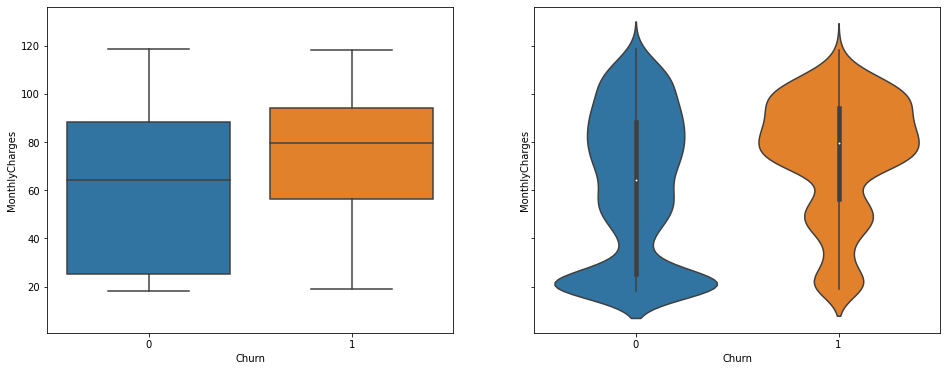

In [70]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))

sns.boxplot(x='Churn', y='MonthlyCharges', data=data, ax=axes[0]);
sns.violinplot(x='Churn', y='MonthlyCharges', data=data, ax=axes[1]);

преобразуем total_charges во float

In [71]:
data['TotalCharges'] 

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

In [72]:
data[data['TotalCharges'].str.match(' ') == False]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.5,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1990.5,0
7039,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,7362.9,0
7040,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,306.6,1


In [73]:
data = data[data['TotalCharges'].str.match(' ') == False]

In [74]:
data['TotalCharges'] = data['TotalCharges'].astype('float64')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


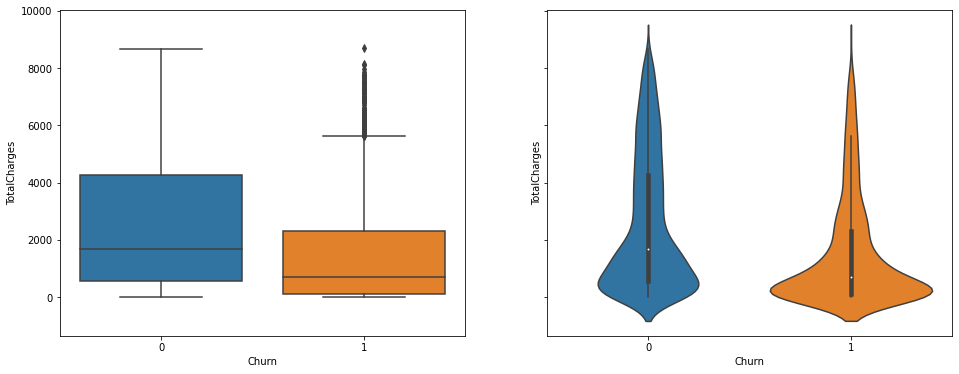

In [75]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))

sns.boxplot(x='Churn', y='TotalCharges', data=data, ax=axes[0]);
sns.violinplot(x='Churn', y='TotalCharges', data=data, ax=axes[1]);

In [76]:
data.TotalCharges.corr(data.MonthlyCharges)

0.6510648032262024

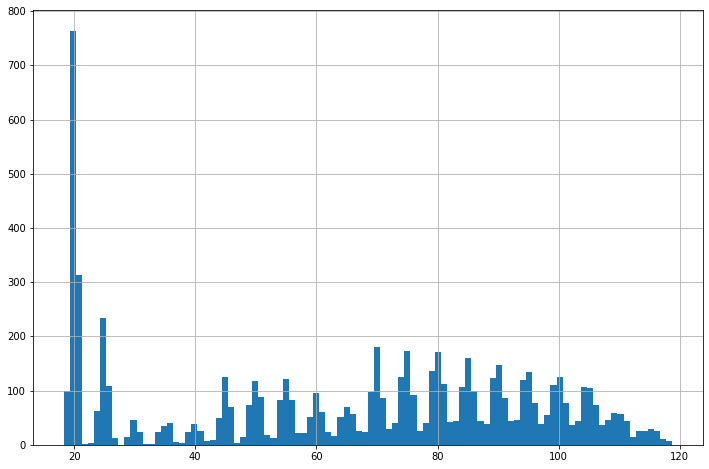

In [77]:
data.MonthlyCharges.hist(bins = 100)

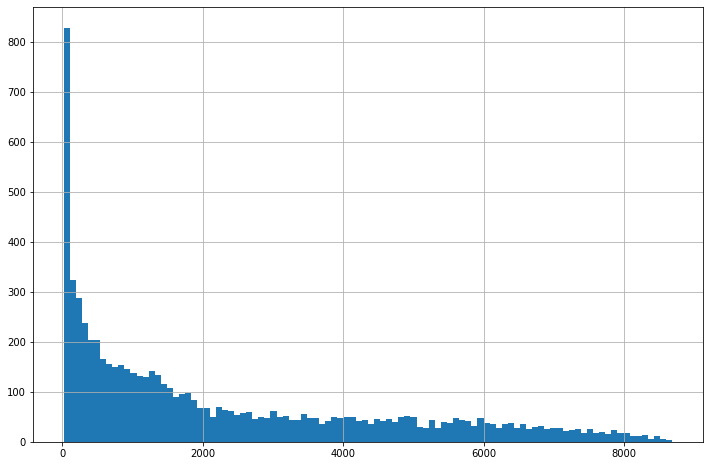

In [78]:
data.TotalCharges.hist(bins = 100)

In [79]:
corr_matrix = data.corr()

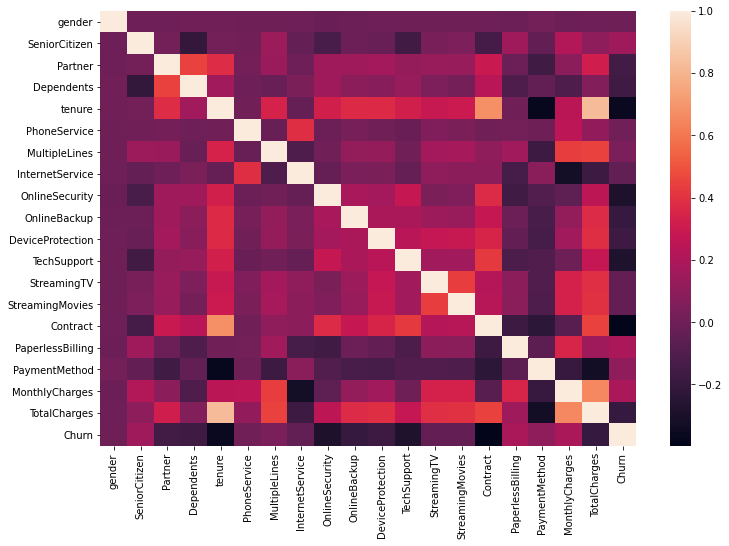

In [80]:
sns.heatmap(corr_matrix);

# Часть 3.Who's the mightiest of them all?

функция качества модели

In [81]:
def quality(prediction_y, true_y):
    accuracy = accuracy_score(prediction_y, true_y)
    precision = precision_score(prediction_y, true_y)
    recall = recall_score(prediction_y, true_y)
    f1 = f1_score(prediction_y, true_y)
    print("Accuracy:  {:.3f}\nPrecision: {:.3f}\nRecall:    {:.3f}\nF1-score:  {:.3f}".format(
        accuracy, precision, recall, f1
    ))

функция построения кривой roc_auc

In [82]:

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

### sklearn RandomForest

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Churn'], axis = 1), data.Churn, test_size=0.3, random_state=2021, stratify=data.Churn.values)

In [84]:
clfRF = RandomForestClassifier()
clfRF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [85]:
predRF = clfRF.predict(X_test)

In [86]:
print("Train quality:")
quality(clfRF.predict(X_train), y_train)
print("\nTest quality:")
quality(predRF, y_test)

Train quality:
Accuracy:  0.998
Precision: 0.994
Recall:    0.997
F1-score:  0.995

Test quality:
Accuracy:  0.779
Precision: 0.453
Recall:    0.614
F1-score:  0.521


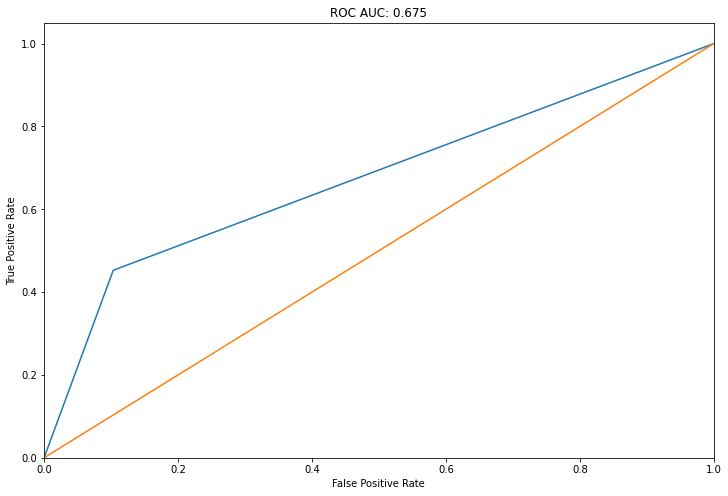

In [87]:
plot_roc_curve(predRF, y_test)

### XGBoost

In [88]:
clfXGB = XGBClassifier()
clfXGB.fit(X_train, y_train)
predXGB = clfXGB.predict(X_test)

In [89]:
print("Train quality:")
quality(clfXGB.predict(X_train), y_train)
print("\nTest quality:")
quality(predXGB, y_test)

Train quality:
Accuracy:  0.825
Precision: 0.563
Recall:    0.719
F1-score:  0.631

Test quality:
Accuracy:  0.799
Precision: 0.512
Recall:    0.657
F1-score:  0.575


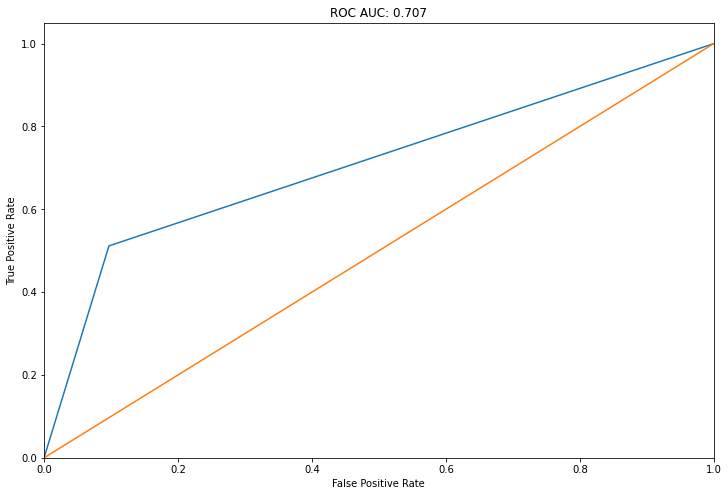

In [90]:
plot_roc_curve(predXGB, y_test)

### CatBost

In [91]:
clfcat = CatBoostClassifier(eval_metric='AUC')
clfcat.fit(X_train, y_train, silent= True)
predcat = clfcat.predict(X_test)

In [92]:
print("Train quality:")
quality(clfcat.predict(X_train), y_train)
print("\nTest quality:")
quality(predcat, y_test)

Train quality:
Accuracy:  0.880
Precision: 0.694
Recall:    0.828
F1-score:  0.755

Test quality:
Accuracy:  0.789
Precision: 0.506
Recall:    0.627
F1-score:  0.560


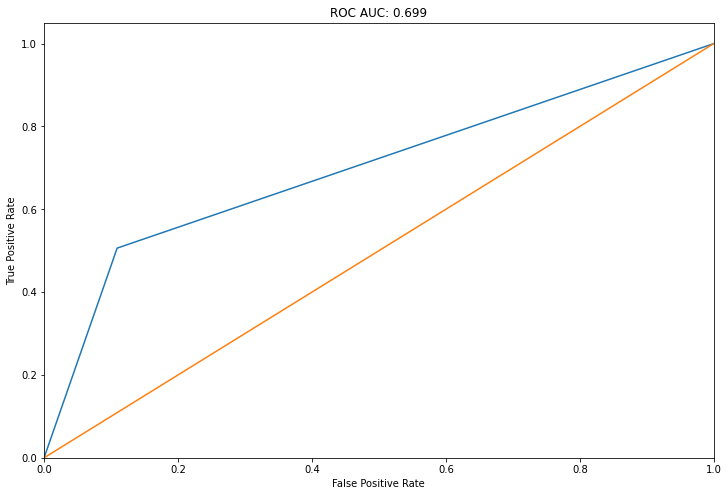

In [93]:
plot_roc_curve(predcat, y_test)

### LightGBM

In [94]:
clfLBM = LGBMClassifier()
clfLBM.fit(X_train, y_train)
predLBM = clfLBM.predict(X_test)

In [95]:
print("Train quality:")
quality(clfLBM.predict(X_train), y_train)
print("\nTest quality:")
quality(predLBM, y_test)

Train quality:
Accuracy:  0.889
Precision: 0.722
Recall:    0.836
F1-score:  0.775

Test quality:
Accuracy:  0.784
Precision: 0.497
Recall:    0.616
F1-score:  0.550


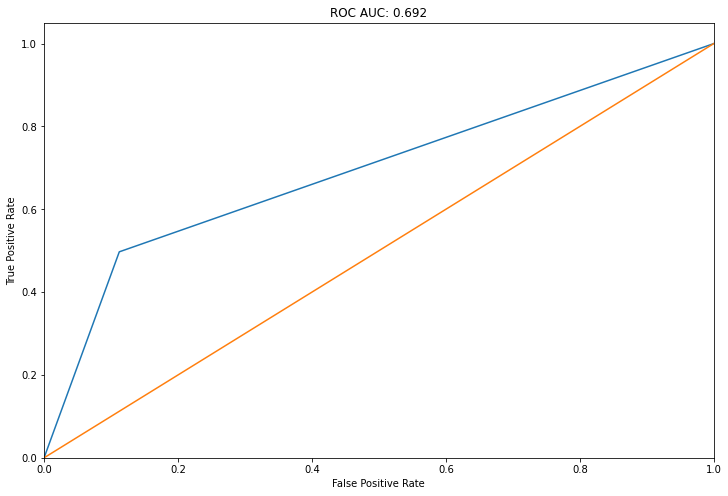

In [96]:
plot_roc_curve(predLBM, y_test)

### sklearn RandomForest, XGBoost, CatBost, LightGBM (настройка гиперпараметров)

---



Инициализируем страифицированную разбивку нашего датасета для валидации

In [97]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

sklearn RandomForest

In [99]:
parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv_rf = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv_rf.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              

In [100]:
print("Train quality:")
quality(gcv_rf.predict(X_train), y_train)
print("\nTest quality:")
quality(gcv_rf.predict(X_test), y_test)

Train quality:
Accuracy:  0.869
Precision: 0.633
Recall:    0.834
F1-score:  0.720

Test quality:
Accuracy:  0.791
Precision: 0.481
Recall:    0.643
F1-score:  0.550


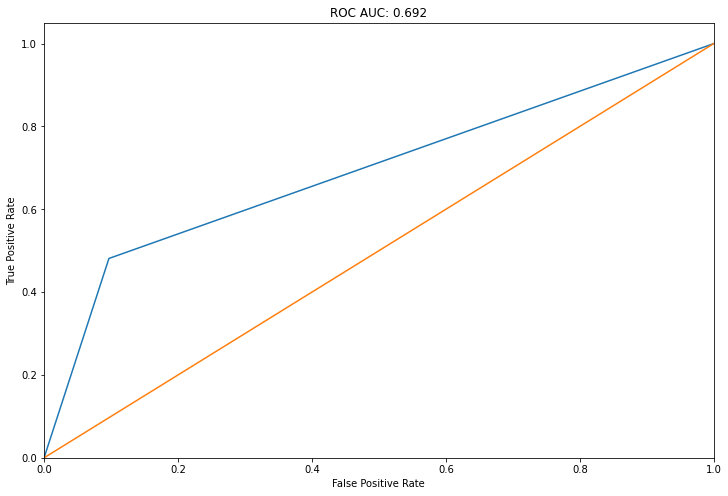

In [101]:
plot_roc_curve(gcv_rf.predict(X_test), y_test)

XGBoost

In [103]:
xgbc = XGBClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv_x = GridSearchCV(xgbc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv_x.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  4.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     oob_score=True, random_state=42,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],

In [104]:
print("Train quality:")
quality(gcv_x.predict(X_train), y_train)
print("\nTest quality:")
quality(gcv_x.predict(X_test), y_test)

Train quality:
Accuracy:  0.856
Precision: 0.635
Recall:    0.782
F1-score:  0.700

Test quality:
Accuracy:  0.798
Precision: 0.515
Recall:    0.652
F1-score:  0.576


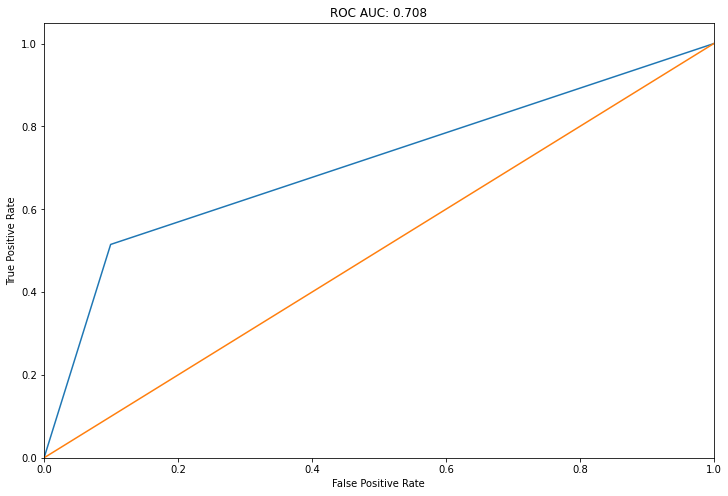

In [105]:
plot_roc_curve(gcv_x.predict(X_test), y_test)

CatBost

In [106]:
param_cat = {'iterations': [1,5,10,20,50], 'subsample': [0.66, 0.8,1], 'max_depth': [5,10,15,20]}
catc = CatBoostClassifier(random_state=42, 
                             eval_metric='AUC')
gcv_c = GridSearchCV(catc, param_cat, n_jobs=-1, cv=skf, verbose=1)
gcv_c.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:  2.1min


Learning rate set to 0.317339
0:	total: 2.01ms	remaining: 98.7ms
1:	total: 3.78ms	remaining: 90.7ms
2:	total: 5.03ms	remaining: 78.8ms
3:	total: 6.82ms	remaining: 78.5ms
4:	total: 8.62ms	remaining: 77.6ms
5:	total: 10.4ms	remaining: 76.3ms
6:	total: 12.3ms	remaining: 75.3ms
7:	total: 14ms	remaining: 73.6ms
8:	total: 16ms	remaining: 72.7ms
9:	total: 17.8ms	remaining: 71.2ms
10:	total: 19.6ms	remaining: 69.4ms
11:	total: 21.5ms	remaining: 68ms
12:	total: 23.4ms	remaining: 66.5ms
13:	total: 25.2ms	remaining: 64.7ms
14:	total: 27ms	remaining: 63ms
15:	total: 28.8ms	remaining: 61.2ms
16:	total: 30.6ms	remaining: 59.4ms
17:	total: 32.4ms	remaining: 57.6ms
18:	total: 34.2ms	remaining: 55.8ms
19:	total: 36ms	remaining: 54ms
20:	total: 37.9ms	remaining: 52.4ms
21:	total: 39.8ms	remaining: 50.6ms
22:	total: 41.5ms	remaining: 48.8ms
23:	total: 43.3ms	remaining: 47ms
24:	total: 45.1ms	remaining: 45.1ms
25:	total: 46.9ms	remaining: 43.3ms
26:	total: 48.8ms	remaining: 41.5ms
27:	total: 50.5ms	remain

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f4a152a5950>,
             iid='deprecated', n_jobs=-1,
             param_grid={'iterations': [1, 5, 10, 20, 50],
                         'max_depth': [5, 10, 15, 20],
                         'subsample': [0.66, 0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [107]:
print("Train quality:")
quality(gcv_c.predict(X_train), y_train)
print("\nTest quality:")
quality(gcv_c.predict(X_test), y_test)

Train quality:
Accuracy:  0.832
Precision: 0.583
Recall:    0.732
F1-score:  0.649

Test quality:
Accuracy:  0.795
Precision: 0.528
Recall:    0.638
F1-score:  0.578


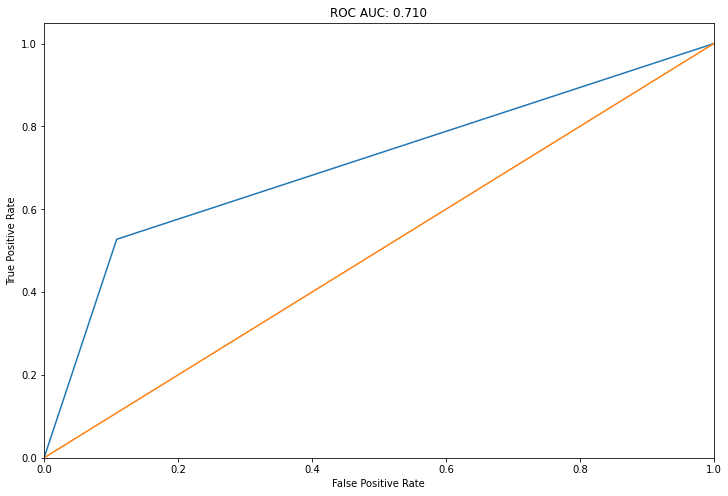

In [108]:
plot_roc_curve(gcv_c.predict(X_test), y_test)

 LightGBM

In [109]:
gbmc = LGBMClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv_l = GridSearchCV(gbmc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv_l.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   36.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      oob_score=True, random_state=42,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid

In [110]:
print("Train quality:")
quality(gcv_l.predict(X_train), y_train)
print("\nTest quality:")
quality(gcv_l.predict(X_test), y_test)

Train quality:
Accuracy:  0.855
Precision: 0.635
Recall:    0.778
F1-score:  0.699

Test quality:
Accuracy:  0.791
Precision: 0.512
Recall:    0.631
F1-score:  0.565


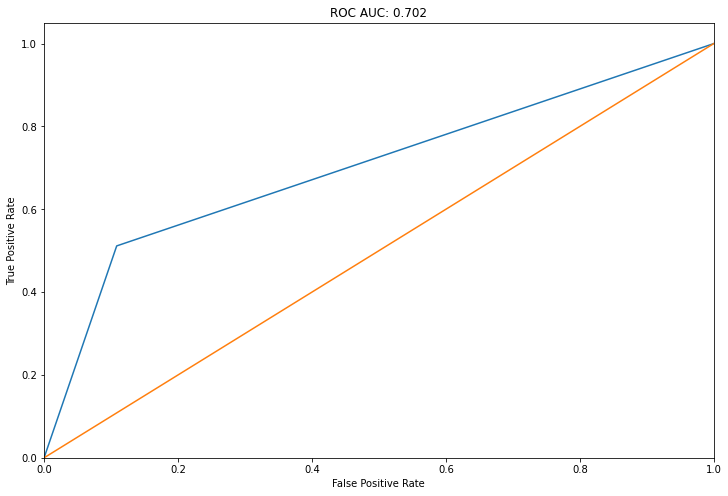

In [111]:
plot_roc_curve(gcv_l.predict(X_test), y_test)

# Выводы



*   без настроек гимперпараметров победила модель XGBOOST auc = 0,707, 2 место - catbost auc = 0,699 (если смотреть по метрике ROC_AUC)
*   с настройками гиперпараметров на кросс валидации победила также модель CATBOST auc = 0,710, 2 место XGBOOST auc = 0,708 

Вопрос: не могу понять, почему такое низкое качество выдали мои модели?
Дело в настроцках фич?



